Transferencia de Hohmann


---- Ventana lanzamiento Tierra → Mercurio ----
 Angulo de fase: 107.90°
 Periodo sinódico: 115.81 días

 Próximas ventanas de lanzamiento:
  - Ventana 1: 02/01/2025
  - Ventana 2: 28/04/2025
  - Ventana 3: 22/08/2025


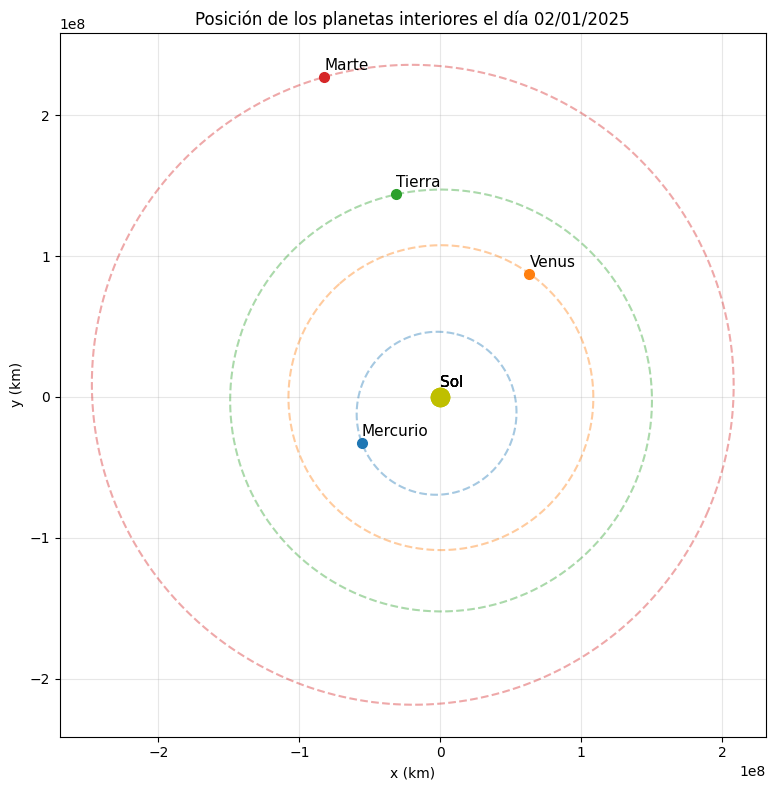

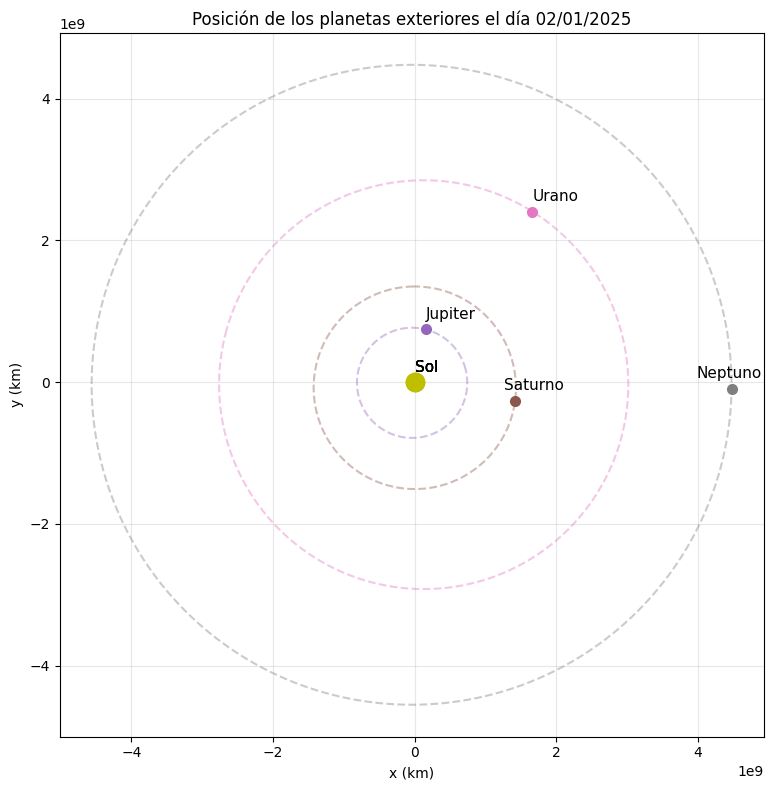


---- Transferencia Hohmann Tierra → Mercurio ----
 Δv inicial: -7.538 km/s
 Δv final: -9.620 km/s
 Δv total: 17.158 km/s
 Tiempo de transferencia: 105.57 días
v_t1 = 22.238 km/s
v_t2 = 57.499 km/s


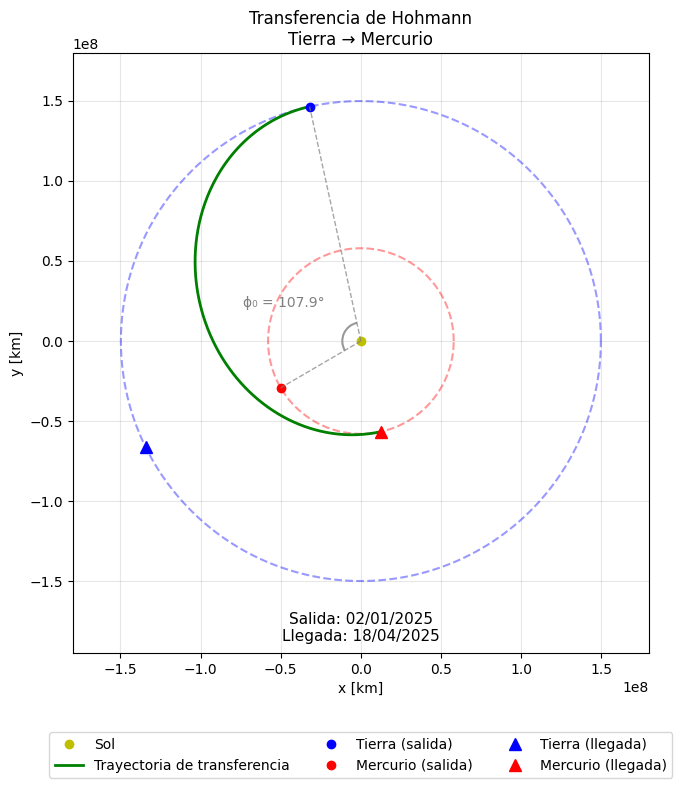

In [ ]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from datetime import datetime, timedelta

t_ref = 2460676.5  # 01.01.2025 juliano
fecha_ref = datetime(2025, 1, 1)

G = 6.67430e-20  # km³ / kg / s²
m_Sol = 1.989e30  # kg
mu_Sol = G * m_Sol

@dataclass
class Planeta:
    nombre: str
    m: float
    a: float  # Semieje mayor (km)
    e: float  # Excentricidad
    omega_deg: float
    Omega_deg: float
    theta0_deg: float

    def __post_init__(self):
        self.mu = G * self.m
        self.T = 2 * np.pi * np.sqrt(self.a**3 / mu_Sol)
        self.omega_rad = np.radians(self.omega_deg)
        self.Omega_rad = np.radians(self.Omega_deg)
        self.theta0_rad = np.radians(self.theta0_deg)

    def calcular_theta(self, t_dias):
        T_dias = self.T / 86400
        omega = 2 * np.pi / T_dias
        theta = (self.theta0_rad + omega * t_dias) % (2 * np.pi)
        return theta

planetas = {
        "Mercurio" : Planeta("Mercurio", 3.302e23, 5.79091e7,
                             2.05638e-1, 2.91956e1, 4.82998e1, 1.25000e2),
        "Venus" : Planeta("Venus",4.869e24, 1.08208e8,
                          6.74657e-3, 5.51507e1, 7.66118e1, 2.79312e2),
        "Tierra" : Planeta("Tierra",5.972e24, 1.49734e8,
                           1.75619e-2, 2.72978e2, 1.90171e2, 3.57319e2),
        "Marte" : Planeta("Marte",6.417e23, 2.27947e8,
                          9.34302e-2, 2.86711e2, 4.94867e1, 1.32697e2),
        "Jupiter" : Planeta("Jupiter",18.982e26, 7.78331e8,
                            4.83062e-2, 2.73609e2, 1.00520e2, 6.38729e1),
        "Saturno" : Planeta("Saturno",5.683e26, 1.42950e9,
                            5.52230e-2, 3.37166e2, 1.13559e2, 2.58734e2),
        "Urano" : Planeta("Urano",8.681e25, 2.88744e9,
                          4.56241e-2, 9.04959e1, 7.40126e1, 2.50887e2),
        "Neptuno" : Planeta("Neptuno",1.024e26, 4.51540e9,
                            1.26610e-2, 2.68115e2, 1.31947e2, 3.18734e2)
    }


def rotar_posicion(x_orbital, y_orbital, planeta):
    r_orbital = np.array([x_orbital, y_orbital, 0])
    cos_Omega = np.cos(-planeta.Omega_rad)
    sin_Omega = np.sin(-planeta.Omega_rad)
    cos_omega = np.cos(-planeta.omega_rad)
    sin_omega = np.sin(-planeta.omega_rad)

    Rz_omega = np.array([
        [cos_omega, sin_omega, 0],
        [-sin_omega, cos_omega, 0],
        [0, 0, 1]])
    Rz_Omega = np.array([
        [cos_Omega, sin_Omega, 0],
        [-sin_Omega, cos_Omega, 0],
        [0, 0, 1]])
    R_total = Rz_Omega @ Rz_omega
    r_espacio = R_total @ r_orbital
    return r_espacio[0], r_espacio[1], r_espacio[2]

def calcular_posicion(planeta, t_dias):
    theta_rad = planeta.calcular_theta(t_dias)
    r = (planeta.a * (1 - planeta.e**2)) / (1 + planeta.e * np.cos(theta_rad))
    x_orbital = r * np.cos(theta_rad)
    y_orbital = r * np.sin(theta_rad)
    x, y, z = rotar_posicion(x_orbital, y_orbital, planeta)
    return x, y, z

def posicion_angular(planeta, t_dias):
    x, y, _ = calcular_posicion(planeta, t_dias)
    angulo_rad = np.arctan2(y, x)
    angulo_deg = np.degrees(angulo_rad) % 360
    return angulo_deg

def calcular_ventana_lanzamiento(planeta_origen, planeta_destino):
    T1 = planeta_origen.T / 86400
    T2 = planeta_destino.T / 86400
    T_syn = 1 / abs(1 / T1 - 1 / T2)
    a_t = (planeta_origen.a + planeta_destino.a) / 2
    t_trans_s = np.pi * np.sqrt(a_t**3 / mu_Sol)
    t_trans_dias = t_trans_s / 86400
    omega_2 = 2 * np.pi / T2
    phi_0 = (np.pi - omega_2 * t_trans_dias) % (2 * np.pi)

    def angulo_relativo(planeta_origen, planeta_destino, t):
        r1 = np.array(calcular_posicion(planeta_origen, t))
        r2 = np.array(calcular_posicion(planeta_destino, t))
        cos_angle = np.dot(r1, r2) / (np.linalg.norm(r1) * np.linalg.norm(r2))
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle = np.arccos(cos_angle)
        cross_z = r1[0]*r2[1] - r1[1]*r2[0]
        if cross_z < 0:
            angle = 2 * np.pi - angle
        return angle % (2 * np.pi)

    pasos = 10000
    tiempos = np.linspace(0, T_syn, pasos)
    diffs = np.array([angulo_relativo(planeta_origen, planeta_destino, t) for t in tiempos])
    diffs_dif = (diffs - phi_0) % (2 * np.pi)

    idx = diffs_dif.argmin()
    t_ventana = tiempos[idx]

    theta_origen_deg = posicion_angular(planeta_origen, t_ventana)
    theta_destino_deg = posicion_angular(planeta_destino, t_ventana)
    phi_0_deg = np.degrees(phi_0)
    fecha_ventana = fecha_ref + timedelta(days=t_ventana)

    return t_ventana, T_syn, phi_0_deg, theta_origen_deg, theta_destino_deg

def graficar_planetas(planetas, t_dias):
    interiores = []
    exteriores = []

    for nombre, planeta in planetas.items():
        if planeta.a <= planetas["Marte"].a:
            interiores.append((nombre, planeta))
        else:
            exteriores.append((nombre, planeta))

    def graficar_conjunto(conjunto, titulo):
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_aspect('equal')
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_title(titulo)
        colores = plt.cm.tab10.colors

        for i, (nombre, planeta) in enumerate(conjunto):
            if conjunto == exteriores:
              color = colores[i+4]
            else:
              color = colores[i]

            theta = np.linspace(0, 2*np.pi, 500)
            r = (planeta.a * (1 - planeta.e**2)) / (1 + planeta.e * np.cos(theta))
            x_orbital = r * np.cos(theta)
            y_orbital = r * np.sin(theta)

            x_rotados = []
            y_rotados = []
            for x, y in zip(x_orbital, y_orbital):
                x_r, y_r, _ = rotar_posicion(x, y, planeta)
                x_rotados.append(x_r)
                y_rotados.append(y_r)
            ax.plot(x_rotados, y_rotados, linestyle='--', color=color, alpha=0.4)
            x, y, _ = calcular_posicion(planeta, t_dias)
            ax.plot(x, y, 'o', markersize=7, color=color, label=f'{nombre}')
            if conjunto == interiores:
              x_min, x_max = ax.get_xlim()
              y_min, y_max = ax.get_ylim()
              if x < 0.9*x_max:
                ax.text(x, y+5e6, nombre, fontsize=11, color='k')
              else:
                ax.text(x-0.1*x_max, y+5e6, nombre, fontsize=11, color='k')
              ax.plot(0, 0, 'yo', markersize=13, label='Sol')
              ax.text(0, 7e6, 'Sol', fontsize=11, color='k')
            else:
              x_min, x_max = ax.get_xlim()
              y_min, y_max = ax.get_ylim()
              if x < 0.9*x_max:
                ax.text(x, y+1.5e8, nombre, fontsize=11, color='k')
              else:
                ax.text(x-0.1*x_max, y+1.5e8, nombre, fontsize=11, color='k')
              ax.plot(0, 0, 'yo', markersize=13, label='Sol')
              ax.text(0, 1.5e8, 'Sol', fontsize=11, color='k')

        ax.grid(True, alpha = 0.3)
        plt.tight_layout()
        plt.show()

    graficar_conjunto(interiores, f'Posición de los planetas interiores el día {(fecha_ref + timedelta(days=t_dias)).strftime("%d/%m/%Y")}')
    graficar_conjunto(exteriores, f'Posición de los planetas exteriores el día {(fecha_ref + timedelta(days=t_dias)).strftime("%d/%m/%Y")}')

def juliano_a_gregoriano(jd):
    JD_2000 = 2451545.0
    fecha_2000 = datetime(2000, 1, 1, 12)
    delta = timedelta(days=(jd - JD_2000))
    fecha = fecha_2000 + delta
    return fecha

def imprimir_ventanas_lanzamiento(planeta_origen, planeta_destino, num_ventanas=3):
    t_ventana_0, T_syn, _, _, _ = calcular_ventana_lanzamiento(planeta_origen, planeta_destino)
    print("\n Próximas ventanas de lanzamiento:")
    for i in range(num_ventanas):
        t_ventana = t_ventana_0 + i * T_syn
        juliano_ventana = t_ref + t_ventana
        fecha_ventana = juliano_a_gregoriano(juliano_ventana)
        print(f"  - Ventana {i+1}: {fecha_ventana.strftime('%d/%m/%Y')}")

def analizar_planetas(planeta_origen, planeta_destino):
    t_ventana, T_syn, phi_0_deg, _, _ = calcular_ventana_lanzamiento(planeta_origen, planeta_destino)
    print(f"\n---- Ventana lanzamiento {planeta_origen.nombre} → {planeta_destino.nombre} ----")
    print(f" Angulo de fase: {phi_0_deg:.2f}°")
    print(f" Periodo sinódico: {T_syn:.2f} días")

    imprimir_ventanas_lanzamiento(planeta_origen, planeta_destino)
    graficar_planetas(planetas, t_ventana)


###################### ↑ Código Completo ↑ ######################

#################################################################

#################### ↓ Código Simplificado ↓ ####################

@dataclass
class Planeta_simplificado:
    nombre: str
    m: float
    r: float
    theta0_deg: float

    def __post_init__(self):
        self.mu = G * self.m
        self.T = 2 * np.pi * np.sqrt(self.r**3 / mu_Sol)
        self.v = np.sqrt(mu_Sol / self.r)
        self.theta0_rad = np.radians(self.theta0_deg)

    def calcular_theta(self, t_dias):
        T_dias = self.T / 86400
        omega = 2 * np.pi / T_dias
        return (self.theta0_rad + omega * t_dias) % (2 * np.pi)

def calcular_transferencia_hohmann(planeta_origen, planeta_destino):
    r1 = planeta_origen.r
    r2 = planeta_destino.r
    v1 = planeta_origen.v
    v2 = planeta_destino.v
    a_t = (r1 + r2) / 2
    v_t1 = np.sqrt(mu_Sol * (2/r1 - 1/a_t))
    v_t2 = np.sqrt(mu_Sol * (2/r2 - 1/a_t))
    delta_v1 = v_t1 - v1
    delta_v2 = v2 - v_t2
    delta_v_total = abs(delta_v1) + abs(delta_v2)
    T_transf = np.pi * np.sqrt(a_t**3 / mu_Sol)
    T_transf_dias = T_transf / 86400
    return {
        "r1": r1, "r2": r2,
        "v1": v1, "v2": v2,
        "v_t1": v_t1, "v_t2": v_t2,
        "delta_v1": delta_v1,
        "delta_v2": delta_v2,
        "delta_v_total": delta_v_total,
        "tiempo_transf_dias": T_transf_dias
    }

def analisis_transferencia(planeta_origen, planeta_destino):
    datos_transf = calcular_transferencia_hohmann(planeta_origen, planeta_destino)
    T_syn = (planeta_origen.T/86400 * planeta_destino.T/86400) / abs(planeta_origen.T/86400 - planeta_destino.T/86400)
    print(f"\nAnálisis transferencia simplificada entre {planeta_origen.nombre} y {planeta_destino.nombre}:")
    print(f"Delta V total: {datos_transf['delta_v_total']:.4f} km/s")
    print(f"Tiempo de transferencia: {datos_transf['tiempo_transf_dias']:.2f} días")
    print(f"Periodo sinódico: {T_syn:.2f} días")
    return datos_transf

def graficar_transferencia(datos, theta1_0=None, theta2_0=None):
    planeta_origen = datos["planeta_origen"]
    planeta_destino = datos["planeta_destino"]
    t_lanzamiento = datos["t_lanzamiento"]
    t_transf_dias = datos["tiempo_transf_dias"]
    r1 = planeta_origen.r
    r2 = planeta_destino.r
    a = (r1 + r2) / 2
    e = abs(r2 - r1) / (r1 + r2)

    # Ángulos iniciales en la ventana de lanzamiento
    if theta1_0 is None:
        theta1_0 = planeta_origen.calcular_theta(t_lanzamiento)
    if theta2_0 is None:
        theta2_0 = planeta_destino.calcular_theta(t_lanzamiento)

    # Posiciones iniciales
    x1_0, y1_0 = r1 * np.cos(theta1_0), r1 * np.sin(theta1_0)
    x2_0, y2_0 = r2 * np.cos(theta2_0), r2 * np.sin(theta2_0)

    # Velocidad angular media (rad/día)
    omega1 = 2 * np.pi / (planeta_origen.T / 86400)
    omega2 = 2 * np.pi / (planeta_destino.T / 86400)

    # Ángulo final = ángulo en ventana + omega * t_transf
    theta1_f = (theta1_0 + omega1 * t_transf_dias) % (2 * np.pi)
    theta2_f = (theta2_0 + omega2 * t_transf_dias) % (2 * np.pi)

    # Posiciones finales (en órbita circular)
    x1_f, y1_f = r1 * np.cos(theta1_f), r1 * np.sin(theta1_f)
    x2_f, y2_f = r2 * np.cos(theta2_f), r2 * np.sin(theta2_f)

    # Órbitas completas
    theta_full = np.linspace(0, 2 * np.pi, 500)
    orb1_x = r1 * np.cos(theta_full)
    orb1_y = r1 * np.sin(theta_full)
    orb2_x = r2 * np.cos(theta_full)
    orb2_y = r2 * np.sin(theta_full)

    # Órbita de transferencia
    theta_transf = np.linspace(0, np.pi, 300)
    r_transf = a * (1 - e**2) / (1 + e * np.cos(theta_transf))

    if r1 < r2:
        theta_offset = theta1_0
        x_transf = r_transf * np.cos(theta_offset + theta_transf)
        y_transf = r_transf * np.sin(theta_offset + theta_transf)
    else:
        theta_offset = theta1_0 + np.pi
        x_transf = r_transf * np.cos(theta_offset - theta_transf)
        y_transf = r_transf * np.sin(theta_offset - theta_transf)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(0, 0, 'yo', label='Sol')

    # Órbitas
    ax.plot(orb1_x, orb1_y, 'b--', alpha=0.4)
    ax.plot(orb2_x, orb2_y, 'r--', alpha=0.4)
    ax.plot(x_transf, y_transf, 'g-', linewidth=2, label='Trayectoria de transferencia')

    # Posiciones iniciales planetas
    ax.plot(x1_0, y1_0, 'bo', label=f'{planeta_origen.nombre} (salida)')
    ax.plot(x2_0, y2_0, 'ro', label=f'{planeta_destino.nombre} (salida)')

    # Posiciones finales planetas
    ax.plot(x1_f, y1_f, 'b^', markersize=8, label=f'{planeta_origen.nombre} (llegada)')
    ax.plot(x2_f, y2_f, 'r^', markersize=8, label=f'{planeta_destino.nombre} (llegada)')

    # Ángulo de fase
    phi_deg = np.degrees((theta2_0 - theta1_0) % (2 * np.pi))
    arc = Arc((0, 0), 0.4 * r2, 0.4 * r2, angle=0,
              theta1=np.degrees(theta1_0),
              theta2=np.degrees(theta2_0),
              color='gray', alpha= 0.8, linewidth=1.5)
    ax.add_patch(arc)

    ax.plot([0, x1_0], [0, y1_0], '--', color='gray', alpha= 0.7, linewidth=1)
    ax.plot([0, x2_0], [0, y2_0], '--', color='gray', alpha= 0.7, linewidth=1)

    x_text = 0.35 * max(r1, r2) * np.cos((theta1_0 + theta2_0) / 2)
    y_text = 0.35 * max(r1, r2) * np.sin((theta1_0 + theta2_0) / 2)
    ax.text(x_text, y_text, f"\u03D5\u2080 = {phi_deg:.1f}°", fontsize=10, color='gray', ha='center')

    # Fechas lanzamiento y llegada
    fecha_lanzamiento = fecha_ref + timedelta(days=t_lanzamiento)
    fecha_llegada = fecha_lanzamiento + timedelta(days=t_transf_dias)
    texto_fecha = f"Salida: {fecha_lanzamiento.strftime('%d/%m/%Y')}\nLlegada: {fecha_llegada.strftime('%d/%m/%Y')}"
    ax.text(0, -1.25 * max(r1, r2), texto_fecha, ha='center', fontsize=11)

    # configuración del gráfico
    max_r = 1.2 * max(r1, r2)
    ax.set_xlim(-max_r, max_r)
    ax.set_ylim(-1.3 * max(r1, r2), max_r)
    ax.set_aspect('equal')
    ax.set_xlabel("x [km]")
    ax.set_ylabel("y [km]")
    ax.set_title(f"Transferencia de Hohmann\n{planeta_origen.nombre} → {planeta_destino.nombre}")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def transferencia_hohmann(planeta_origen_full, planeta_destino_full):
    t_ventana, T_syn, phi_0_deg, theta_origen_iner_deg, theta_destino_iner_deg = calcular_ventana_lanzamiento(planeta_origen_full, planeta_destino_full)

    planeta_origen_simp = Planeta_simplificado(
        nombre=planeta_origen_full.nombre,
        m=planeta_origen_full.m,
        r=planeta_origen_full.a,
        theta0_deg=theta_origen_iner_deg)

    planeta_destino_simp = Planeta_simplificado(
        nombre=planeta_destino_full.nombre,
        m=planeta_destino_full.m,
        r=planeta_destino_full.a,
        theta0_deg=theta_destino_iner_deg)

    datos_transf = calcular_transferencia_hohmann(planeta_origen_simp, planeta_destino_simp)
    datos_transf.update({
        "planeta_origen": planeta_origen_simp,
        "planeta_destino": planeta_destino_simp,
        "t_lanzamiento": t_ventana})

    print(f"\n---- Transferencia Hohmann {planeta_origen_simp.nombre} → {planeta_destino_simp.nombre} ----")
    print(f" \u0394v inicial: {datos_transf['delta_v1']:.3f} km/s")
    print(f" \u0394v final: {datos_transf['delta_v2']:.3f} km/s")
    print(f" \u0394v total: {datos_transf['delta_v_total']:.3f} km/s")
    if datos_transf['tiempo_transf_dias'] > 365:
        print(f" Tiempo de transferencia: {datos_transf['tiempo_transf_dias']:.2f} días, {datos_transf['tiempo_transf_dias'] / 365:.2f} años")
    else:
        print(f" Tiempo de transferencia: {datos_transf['tiempo_transf_dias']:.2f} días")

    print(f'v_t1 = {datos_transf["v_t1"]:.3f} km/s')
    print(f'v_t2 = {datos_transf["v_t2"]:.3f} km/s')

    graficar_transferencia(datos_transf,
                           theta1_0=np.radians(theta_origen_iner_deg),
                           theta2_0=np.radians(theta_destino_iner_deg))


def main():
    planeta_origen = planetas["Tierra"]
    planeta_destino = planetas["Mercurio"]

    analizar_planetas(planeta_origen, planeta_destino)
    transferencia_hohmann(planeta_origen, planeta_destino)

if __name__ == "__main__":
    main()


Asistencia Gravitacional


 ========== TRANSFERENCIA ÓPTIMA ENCONTRADA ==========
               Tierra → Marte → Saturno               

  - Impulso total = 18.361 km/s
  - Impulso en flyby = 10.5 km/s
  - Radio de apuntado en flyby = 4896 km
  → Error relativo respecto a la órbita de Marte: 0.0021%


---- Transferencia de Hohmann Tierra → Marte ----
 Impulso requerido: Δv = 2.938 km/s
 Tiempo de transferencia: t = 259.0 días


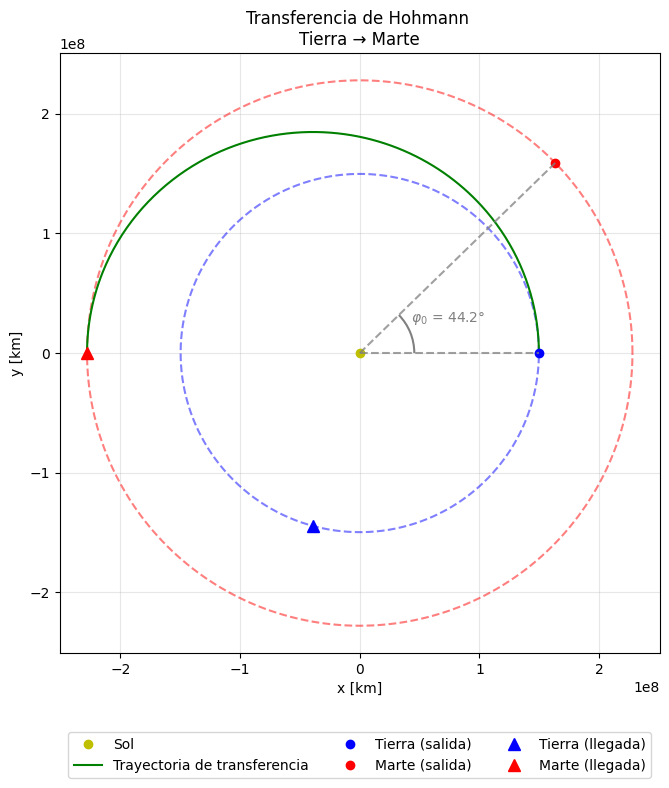

---- Flyby en Marte ----
 - Datos pre-flyby:
    Velocidad de la nave: v_t2 = 21.489 km/s
    Velocidad de Marte: v_p = 24.133 km/s
    Velocidad relativa entre la nave y Marte: v_rel = -2.644 km/s
    Impulso dado: Δv = 10.500 km/s
    Velocidad de exceso hiperbólico (v_rel + Δv): v∞ = 7.856 km/s

 - Datos post-flyby:
    Ángulo de giro: δ = 16.1°
    Velocidad planetocéntrica de la nave: v_p,nave = [2.183, -7.547] km/s
    Energía específica planetocéntrica: ε = 3.086e+01 km²/s² → Hipérbola respecto a Marte

    Velocidad heliocéntrica del planeta: v_h,Marte = [-0.000, -24.133] km/s
    Velocidad heliocéntrica de la nave: v_h,nave = [2.183, -31.680] km/s
    Energía específica heliocéntrica: ε_sol = -7.820e+01 km²/s² → órbita elíptica (ligada al Sol)
    Elementos orbitales de la órbita final:
       a = 848.79·10^6 km
       e = 0.7314
       rp = 227.95·10^6 km
       ra = 1469.63·10^6 km
     → Cruza la órbita de Saturno.


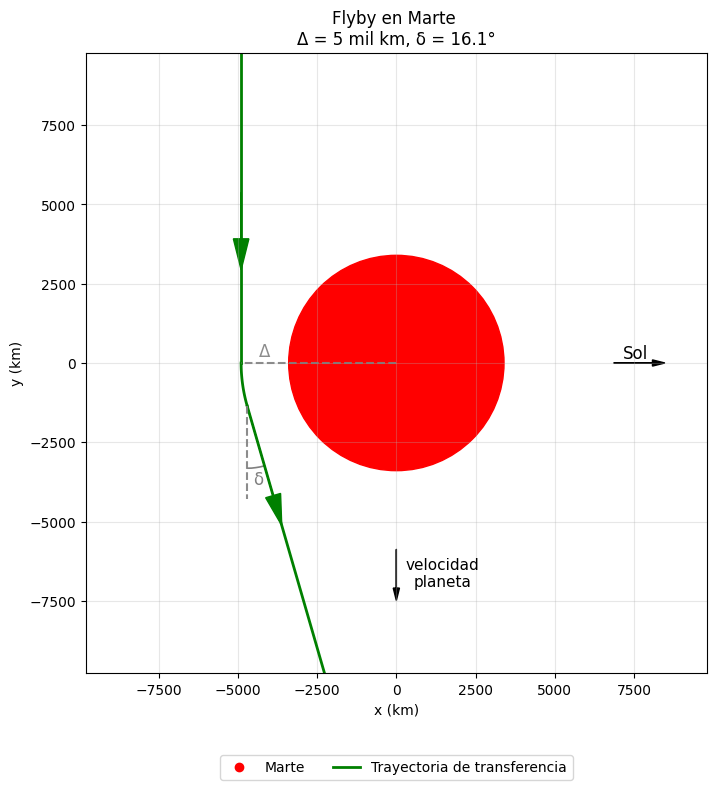


---- Intersecciones con la órbita de Saturno ----
 - Intersección 1, θ = 172.20°:
    Velocidad de Saturno: v_p,1: [1.306,9.534] = 9.623 km/s
    Velocidad de la nave: v_n,1 = [2.489,4.756] = 5.368 km/s
    Tiempo desde flyby = 2005.38 días
    Impulso para inserción: Δv = 4.923 km/s
    Angulo de fase entre Marte y Saturno = 105.56°

 - Intersección 2, θ = 187.80°:
    Velocidad de Saturno: v_p,2: [-1.306,9.534] = 9.623 km/s
    Velocidad de la nave: v_n,2 = [-2.489,4.756] = 5.368 km/s
    Tiempo desde flyby: t = 2930.27 días
    Impulso para inserción: Δv = 4.923 km/s
    Angulo de fase entre Marte y Saturno = 90.42°


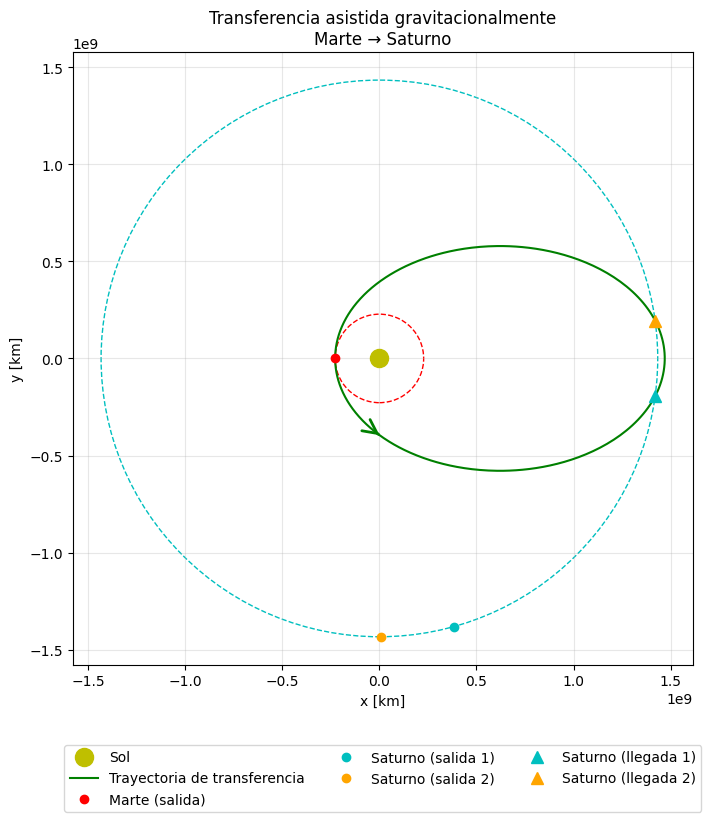


---- Maniobra de transferencia con asistencia gravitacional ----
                       Tierra-Marte-Saturno                      

 Impulso total de transferencia: Δv = 18.361 km/s
 Tiempo total de transferencia para intersección 1: t = 2264.4 días = 6.20 años
 Tiempo total de transferencia para intersección 2: t = 3189.2 días = 8.74 años

 Angulo de fase entre Tierra y Marte = 44.2°
 Angulo de fase entre Tierra y Saturno (intersección 1) = 96.9°
 Angulo de fase entre Tierra y Saturno (intersección 2) = 81.8°


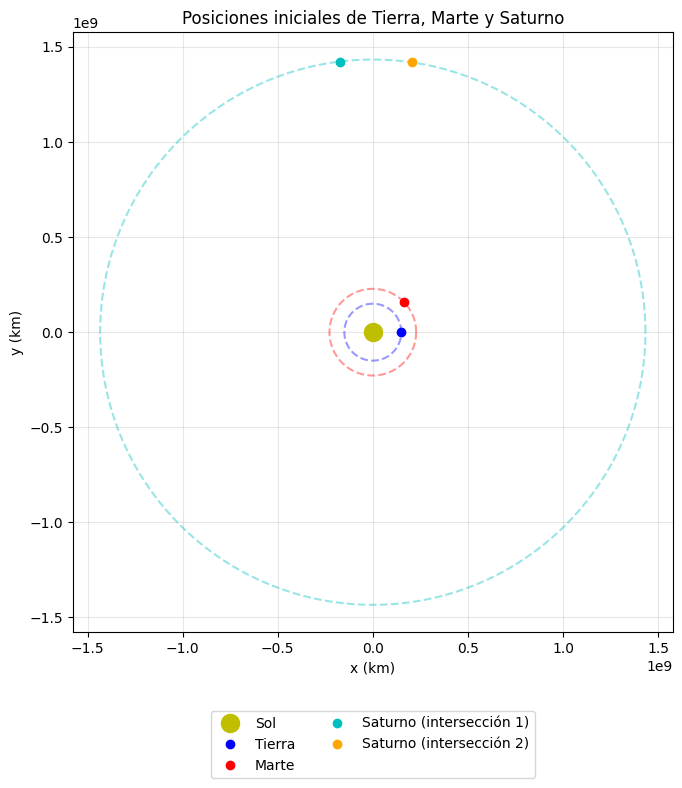

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from matplotlib.patches import Arc


G = 6.67430e-20  # km^3/kg/s^2
m_Sol = 1.989e30  # kg
mu_Sol = G * m_Sol

@dataclass
class Planeta:
    nombre: str
    m: float
    r: float
    theta0_deg: float
    radio: float

    def __post_init__(self):
        self.mu = G * self.m
        self.T = 2 * np.pi * np.sqrt(self.r**3 / mu_Sol) / 86400
        self.v = np.sqrt(mu_Sol / self.r)
        self.omega = 2 * np.pi / self.T
        self.theta0_rad = np.radians(self.theta0_deg)

planetas = {
    "Mercurio" : Planeta("Mercurio", 3.3011e23, 5.791e7, 0, 2439.7),
    "Venus" : Planeta("Venus",4.869e24, 1.08208e8, 305.8, 6051.9),
    "Tierra" : Planeta("Tierra",5.972e24, 1.49734e8, 0, 6378.1),
    "Marte" : Planeta("Marte",6.417e23, 2.27947e8, 44.2, 3396.2),
    "Jupiter": Planeta("Jupiter", 1.898e27, 7.785e8, 0, 71492),
    "Saturno": Planeta("Saturno", 5.683e26, 1.4335e9, 0, 60268),
    "Urano"    : Planeta("Urano", 8.6810e25, 2.8725e9, 0, 25559),
    "Neptuno"  : Planeta("Neptuno", 1.0243e26, 4.4951e9, 0, 24764)
}

def calcular_Hohmann_alfa_bravo(alfa, bravo):
    a_t = (alfa.r + bravo.r)/2
    e_t = abs(alfa.r - bravo.r) / (alfa.r + bravo.r)
    t_transf = np.pi * np.sqrt(a_t**3 / mu_Sol) / 86400
    v_t1 = np.sqrt(mu_Sol * (2 / alfa.r - 1 / a_t))
    v_t2 = np.sqrt(mu_Sol * (2 / bravo.r - 1 / a_t))
    delta_v = v_t1 - alfa.v

    return delta_v, t_transf, a_t, e_t

def graficar_Hohmann(alfa, bravo):
    delta_v, t_transf, a_t, e_t = calcular_Hohmann_alfa_bravo(alfa, bravo)

    print(f"---- Transferencia de Hohmann {alfa.nombre} → {bravo.nombre} ----")
    print(f" Impulso requerido: \u0394v = {delta_v:.3f} km/s")
    print(f" Tiempo de transferencia: t = {t_transf:.1f} días")

    theta_transf = np.linspace(0, np.pi, 300)
    r_transf = a_t * (1 - e_t**2) / (1 + e_t * np.cos(theta_transf))

    if alfa.r < bravo.r:
        x_transf = r_transf * np.cos(alfa.theta0_rad + theta_transf)
        y_transf = r_transf * np.sin(alfa.theta0_rad + theta_transf)
    else:
        x_transf = r_transf * np.cos(alfa.theta0_rad + np.pi - theta_transf)
        y_transf = r_transf * np.sin(alfa.theta0_rad + np.pi - theta_transf)

    theta_circ = np.linspace(0, 2*np.pi, 500)
    x_alfa = alfa.r * np.cos(theta_circ)
    y_alfa = alfa.r * np.sin(theta_circ)
    x_bravo = bravo.r * np.cos(theta_circ)
    y_bravo = bravo.r * np.sin(theta_circ)

    theta_alfa_f = (alfa.theta0_rad + alfa.omega * t_transf) % (2 * np.pi)
    theta_bravo_f = (bravo.theta0_rad + bravo.omega * t_transf) % (2 * np.pi)

    r0_alfa = alfa.r * np.array([np.cos(alfa.theta0_rad),
                                 np.sin(alfa.theta0_rad)])
    r1_alfa = alfa.r * np.array([np.cos(theta_alfa_f),
                                 np.sin(theta_alfa_f)])
    r0_bravo = bravo.r * np.array([np.cos(bravo.theta0_rad),
                                   np.sin(bravo.theta0_rad)])
    r1_bravo = bravo.r * np.array([np.cos(theta_bravo_f),
                                   np.sin(theta_bravo_f)])

    phi0 = (bravo.theta0_rad - alfa.theta0_rad) % (2 * np.pi)
    phi0_deg = np.degrees(phi0)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(0, 0, 'yo', label='Sol')

    # Órbitas
    ax.plot(x_alfa, y_alfa, 'b--', alpha=0.5)
    ax.plot(x_bravo, y_bravo, 'r--', alpha=0.5)
    ax.plot(x_transf, y_transf, 'g', label='Trayectoria de transferencia')

    # Planetas
    ax.plot(*r0_alfa, 'bo', label=f'{alfa.nombre} (salida)')
    ax.plot(*r0_bravo, 'ro', label=f'{bravo.nombre} (salida)')
    ax.plot(*r1_alfa, 'b^', markersize=8,
            label=f'{alfa.nombre} (llegada)')
    ax.plot(*r1_bravo, 'r^', markersize=8,
            label=f'{bravo.nombre} (llegada)')

    # Ángulo de fase
    arco = Arc((0, 0), width=0.4*bravo.r, height=0.4*bravo.r, angle=0,
               theta1=alfa.theta0_deg,theta2=bravo.theta0_deg,
               color='gray', linewidth=1.5)
    ax.add_patch(arco)
    ax.plot([0, r0_alfa[0]], [0, r0_alfa[1]], 'gray',
            alpha=0.75, linestyle='--')
    ax.plot([0, r0_bravo[0]], [0, r0_bravo[1]], 'gray',
            alpha=0.75, linestyle='--')

    x_text = 0.35 * max(alfa.r, bravo.r) * np.cos((alfa.theta0_rad + bravo.theta0_rad)/2)
    y_text = 0.3 * max(alfa.r, bravo.r) * np.sin((alfa.theta0_rad + bravo.theta0_rad)/2)
    ax.text(x_text, y_text, f"$\\varphi_0$ = {phi0_deg:.1f}°",
            fontsize=10, color='gray', ha='center')

    # Configuración gráfico
    ax.set_aspect('equal')
    ax.set_xlabel("x [km]")
    ax.set_ylabel("y [km]")
    ax.set_title(f"Transferencia de Hohmann \n{alfa.nombre} → {bravo.nombre}")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return delta_v,t_transf

def calcular_flyby(alfa, bravo, charlie, Delta, impulso):
    a_t = (alfa.r + bravo.r) / 2
    v_t2 = np.sqrt(mu_Sol * (2 / bravo.r - 1 / a_t))
    v_infi = (v_t2 - bravo.v) + impulso

    delta_rad = 2 * np.arcsin(1 / np.sqrt(1 + (Delta**2 * v_infi**4) / bravo.mu**2))

    vx = v_infi * np.sin(delta_rad)
    vy = -v_infi * np.cos(delta_rad)
    v_rel_out = np.array([vx, vy])

    theta_p = np.radians(180)
    v_planeta = np.array([-bravo.v * np.sin(theta_p), bravo.v * np.cos(theta_p)])
    v_helio = v_planeta + v_rel_out

    x3_ini = -Delta * np.cos(delta_rad)
    y3_ini = Delta * np.sin(delta_rad)
    ang_salida = - (np.pi / 2 - delta_rad)
    x_out = x3_ini + 4 * Delta * np.cos(ang_salida)
    y_out = y3_ini + 4 * Delta * np.sin(ang_salida)

    r_planeta = np.array([bravo.r * np.cos(theta_p), bravo.r * np.sin(theta_p)])
    r_vec = r_planeta + np.array([x_out, y_out])
    r = np.linalg.norm(r_vec)

    energ_sol = 0.5 * np.dot(v_helio, v_helio) - mu_Sol / r

    if energ_sol < 0:
        a = -mu_Sol / (2 * energ_sol)
        rp = r
        e = 1 - rp / a
        ra = a * (1 + e)
        return a, e  # órbita elíptica
    else:
        return None, None  # órbita hiperbólica, sin retorno útil

def graficar_flyby(alfa, bravo, charlie, Delta, impulso):
    a_t = (alfa.r + bravo.r) / 2
    v_t2 = np.sqrt(mu_Sol * (2 / bravo.r - 1 / a_t))
    v_infi = (v_t2 - bravo.v) + impulso
    print(f"---- Flyby en {bravo.nombre} ----")
    print(" - Datos pre-flyby:")
    print(f"    Velocidad de la nave: v_t2 = {(v_t2):.3f} km/s")
    print(f"    Velocidad de {bravo.nombre}: v_p = {bravo.v:.5} km/s")
    print(f"    Velocidad relativa entre la nave y {bravo.nombre}: v_rel = {(v_t2 - bravo.v):.3f} km/s")
    print(f"    Impulso dado: \u0394v = {impulso:.3f} km/s")
    print(f"    Velocidad de exceso hiperbólico (v_rel + \u0394v): v\u221e = {v_infi:.3f} km/s")

    delta_rad = 2 * np.arcsin(1 / np.sqrt(1 + (Delta**2 * v_infi**4) / bravo.mu**2))
    delta_deg = np.degrees(delta_rad)
    print("\n - Datos post-flyby:")
    print(f"    Ángulo de giro: \u03B4 = {delta_deg:.1f}°")

    vx = v_infi * np.sin(delta_rad)
    vy = -v_infi * np.cos(delta_rad)
    v_rel_out = np.array([vx, vy])
    print(f"    Velocidad planetocéntrica de la nave: v_p,nave = [{v_rel_out[0]:.3f}, {v_rel_out[1]:.3f}] km/s")

    theta_p = np.radians(180)
    v_planeta = np.array([-bravo.v * np.sin(theta_p), bravo.v * np.cos(theta_p)])
    v_helio = v_planeta + v_rel_out

    x1 = [-Delta]
    y1 = [3 * Delta, 0]

    theta = np.linspace(0, -delta_rad, 100)
    arco_x = -Delta * np.cos(theta)
    arco_y = Delta * np.sin(theta)

    x3_ini = arco_x[-1]
    y3_ini = arco_y[-1]
    ang_salida = - (np.pi / 2 - delta_rad)
    x3 = [x3_ini, x3_ini + 4 * Delta * np.cos(ang_salida)]
    y3 = [y3_ini, y3_ini + 4 * Delta * np.sin(ang_salida)]

    eps = 0.5 * v_infi**2 - bravo.mu/bravo.r
    if eps < 0:
        tipo = "Elipse"
    elif abs(eps) < 1e-8:
        tipo = "Parábola"
    else:
        tipo = "Hipérbola"
    print(f"    Energía específica planetocéntrica: ε = {eps:.3e} km²/s² → {tipo} respecto a {bravo.nombre}")

    theta_p = np.radians(180)
    v_planeta = np.array([-bravo.v * np.sin(theta_p),
        bravo.v * np.cos(theta_p)])
    print(f"\n    Velocidad heliocéntrica del planeta: v_h,{bravo.nombre} = [{v_planeta[0]:.3f}, {v_planeta[1]:.3f}] km/s")

    v_helio = v_planeta + v_rel_out
    print(f"    Velocidad heliocéntrica de la nave: v_h,nave = [{v_helio[0]:.3f}, {v_helio[1]:.3f}] km/s")

    # Posición de salida en heliocéntrico:
    r_planeta = np.array([bravo.r * np.cos(theta_p),
        bravo.r * np.sin(theta_p)])
    r_vec = r_planeta + np.array([x3[-1], y3[-1]])
    r = np.linalg.norm(r_vec)

    energ_sol = 0.5 * np.dot(v_helio, v_helio) - mu_Sol/r
    print(f"    Energía específica heliocéntrica: ε_sol = {energ_sol:.3e} km²/s²", end=' → ')

    if energ_sol >= 0:
        print("órbita hiperbólica (escapa del Sistema Solar)")
    else:
        print("órbita elíptica (ligada al Sol)")

        print(f"    Elementos orbitales de la órbita final:")
        a    = -mu_Sol / (2 * energ_sol)
        r_0   = r
        e    = 1 - r_0/a
        r_1   = a * (1 + e)

        print(f"       a = {a/1e6:.2f}·10^6 km")
        print(f"       e = {e:.4f}")
        if r_1 > r_0:
          print(f"       rp = {r_0/1e6:.2f}·10^6 km")
          print(f"       ra = {r_1/1e6:.2f}·10^6 km")
        else:
          print(f"       rp = {r_1/1e6:.2f}·10^6 km")
          print(f"       ra = {r_0/1e6:.2f}·10^6 km")

        if bravo.r <= charlie.r:
          if r_1 >= charlie.r:
            print(f"     → Cruza la órbita de {charlie.nombre}.")
          else:
            print(f"     → No cruza la órbita de {charlie.nombre}.")
        else:
          if r_1 <= charlie.r:
            print(f"     → Cruza la órbita de {charlie.nombre}.")
          else:
            print(f"     → No cruza la órbita de {charlie.nombre}.")

    fig, ax = plt.subplots(figsize=(8, 8))

    # Planeta
    planeta = plt.Circle((0, 0), bravo.radio, color='r', zorder=0)
    plt.gca().add_patch(planeta)
    plt.plot([], [], 'ro', label=bravo.nombre)

    # Tramos
    plt.plot(x1 * 2, y1, 'g', linewidth=2, label='Trayectoria de transferencia')
    plt.plot(arco_x, arco_y, 'g', linewidth=2)
    plt.plot(x3, y3, 'g', linewidth=2)

    # Línea de paso Δ
    plt.plot([0, -Delta], [0, 0], color='gray', alpha=0.9, linestyle='--')
    plt.text(-bravo.radio - (Delta-bravo.radio)/2, 0.04*Delta,
             '\u0394', ha='center', fontsize=12, color='gray', alpha=0.9)

    # Arco y angulo
    centro_arco = arco_x[-1], arco_y[-1]
    radio_arco = 0.4 * Delta
    angulo_inicio = 270 + delta_deg
    angulo_final = 270

    arc = Arc(centro_arco, 2 * radio_arco, 2 * radio_arco,
              angle=0, theta1=angulo_final, theta2=angulo_inicio,
              color='grey', linewidth=1.2)
    plt.gca().add_patch(arc)

    if delta_deg > 5:
        etiqueta_x = centro_arco[0] - 1.3 * radio_arco * np.cos(np.radians(270- delta_deg / 2))
        etiqueta_y = centro_arco[1] + 1.2 * radio_arco * np.sin(np.radians(270 - delta_deg / 2))
    else:
        etiqueta_x = centro_arco[0] - 0.06 * Delta
        etiqueta_y = centro_arco[1] + 1.2 * radio_arco * np.sin(np.radians(270 - delta_deg / 2))

    plt.text(etiqueta_x, etiqueta_y, f'\u03B4', color='gray',
             fontsize=12, ha='center', va='center')
    long_linea = 0.6 * Delta
    plt.plot([x3_ini, x3_ini], [y3_ini, y3_ini - long_linea],
             color='gray', alpha=0.9, linestyle='--')

    r_SOI = bravo.r * (bravo.m / m_Sol)**(2 / 5)
    limite = 2 * Delta
    if r_SOI <= limite:
        soi = plt.Circle((0, 0), r_SOI, color='gray', fill=False, linestyle='--', label='SOI')
        plt.gca().add_patch(soi)
        limite = 1.05*r_SOI
        # Flechas trayectoria
        plt.arrow(-Delta, 1.1*Delta, 0, -0.3*Delta, head_width=0.05*Delta,
                  head_length=0.1*Delta, fc='g', ec='g')
        dx_salida = 2*Delta * np.cos(ang_salida)
        dy_salida = 2*Delta * np.sin(ang_salida)
        plt.arrow(x3_ini, y3_ini, 0.3*dx_salida, 0.3*dy_salida,
                  head_width=0.05*Delta, head_length=0.1*Delta, fc='g', ec='g')
        # Flechas referencia
        long_flecha = 0.25*Delta
        plt.arrow(0.5*r_SOI, 0, long_flecha, 0, head_width=0.04*Delta,
                  head_length=0.08*Delta, fc='black', ec='black')
        plt.text(0.5*r_SOI + long_flecha/4, 0.06*Delta, 'Sol',
                fontsize=12, va='center')

        plt.arrow(0, -0.5 * r_SOI, 0, -long_flecha,
                  head_width=0.04 * Delta, head_length=0.08 * Delta,
                  fc='black', ec='black')
        plt.text(0.15*Delta, -0.55 * r_SOI, 'velocidad\nplaneta',
                fontsize=11, va='top', ha='center')
    else:
        plt.arrow(-Delta, 1.1*Delta, 0, -0.3*Delta, head_width=0.1*Delta,
                  head_length=0.2*Delta, fc='g', ec='g')
        dx_salida = 2*Delta * np.cos(ang_salida)
        dy_salida = 2*Delta * np.sin(ang_salida)
        plt.arrow(x3_ini, y3_ini, 0.3*dx_salida, 0.3*dy_salida,
                  head_width=0.1*Delta, head_length=0.2*Delta, fc='g', ec='g')

        long_flecha = 0.25*Delta
        plt.arrow(1.4 * Delta, 0, long_flecha, 0, head_width=0.04*Delta,
                  head_length=0.08*Delta, fc='black', ec='black')
        plt.text(1.4 * Delta + long_flecha/4, 0.06*Delta, 'Sol',
                fontsize=12, va='center')

        plt.arrow(0, -1.2 * Delta, 0, -long_flecha,
                  head_width=0.04 * Delta, head_length=0.08 * Delta,
                  fc='black', ec='black')

        plt.text(0.3*Delta, -1.25 * Delta, 'velocidad\nplaneta',
                fontsize=11, va='top', ha='center')

    # Configuración del gráfico
    ax.set_title(f'Flyby en {bravo.nombre} \n\u0394 = {Delta/1000:.0f} mil km, \u03B4 = {delta_deg:.1f}°')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_xlim(-limite, limite)
    ax.set_ylim(-limite, limite)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
    plt.tight_layout()
    plt.show()

def calcular_tras_flyby(a, e, bravo, charlie):
    p = a * (1 - e**2)

    cos_theta_int = (a*(1 - e**2) / charlie.r - 1) / e

    if abs(cos_theta_int) > 1:
        # No hay intersección real
        return None, None, None, None, None, None, None, None, None, False

    theta_int1 = np.arccos(cos_theta_int)
    theta_int2 = 2*np.pi - theta_int1

    def vector_velocidad(theta):
        vr = np.sqrt(mu_Sol / p) * e * np.sin(theta)
        vtheta = np.sqrt(mu_Sol / p) * (1 + e * np.cos(theta))
        vx = -vr * np.cos(theta) + vtheta * np.sin(theta)
        vy = -vr * np.sin(theta) - vtheta * np.cos(theta)
        return np.array([vx, vy])

    v1_vec = vector_velocidad(theta_int1)
    v2_vec = vector_velocidad(theta_int2)
    theta_int1p = theta_int1 + np.pi
    theta_int2p = theta_int2 + np.pi

    v_planeta1 = np.array([-charlie.v * np.sin(theta_int1p), charlie.v * np.cos(theta_int1p)])
    v_planeta2 = np.array([-charlie.v * np.sin(theta_int2p), charlie.v * np.cos(theta_int2p)])

    delta_v1 = np.linalg.norm(v1_vec - v_planeta1)
    delta_v2 = np.linalg.norm(v2_vec - v_planeta2)

    def tiempo_desde_perihelio(theta):
        E = 2 * np.arctan(np.tan(theta/2) / np.sqrt((1+e)/(1-e)))
        if E < 0:
            E += 2*np.pi
        T = 2*np.pi * np.sqrt(a**3 / mu_Sol)
        t = (T / (2*np.pi)) * (E - e * np.sin(E))
        return t / 86400  # en días

    t1 = tiempo_desde_perihelio(theta_int1)
    t2 = tiempo_desde_perihelio(theta_int2)

    def estimar_posicion_destino_inicial(theta_intersecc, tiempo_vuelo_dias):
        t_vuelo_s = tiempo_vuelo_dias * 86400
        omega_dest = np.sqrt(mu_Sol / charlie.r**3)
        theta_dest0 = (theta_intersecc - omega_dest * t_vuelo_s) % (2*np.pi)
        return np.degrees(theta_dest0)

    pos_inicial_1 = estimar_posicion_destino_inicial(theta_int1, t1)
    pos_inicial_2 = estimar_posicion_destino_inicial(theta_int2, t2)

    return delta_v1, t1, t2, pos_inicial_1, pos_inicial_2, v_planeta1, v_planeta2, v1_vec, v2_vec, True

def graficar_tras_flyby(a, e, bravo, charlie, datos):
    delta_v1, t1, t2, pos_inicial_1, pos_inicial_2, v_planeta1, v_planeta2, v1_vec, v2_vec, intersecciones = datos
    modulo_vn1 = np.linalg.norm(v1_vec)
    modulo_vn2 = np.linalg.norm(v2_vec)
    modulo_vp1 = np.linalg.norm(v_planeta1)
    modulo_vp2 = np.linalg.norm(v_planeta2)

    theta = np.linspace(0, 2 * np.pi, 500)
    r = a * (1 - e**2) / (1 + e * np.cos(theta))
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(0, 0, 'yo', markersize=13, label='Sol')
    ax.plot(-x, y, color='green', label='Trayectoria de transferencia')

    #flecha dirección
    theta_flecha = 27 * np.pi / 18
    idx = np.argmin(np.abs(theta - theta_flecha))
    x1, y1 = -x[idx], y[idx]
    x0, y0 = -x[idx + 1], y[idx + 1]
    ax.annotate("", xy=(x1, y1), xytext=(x0, y0),
                arrowprops=dict(arrowstyle="->", color='green',
                                lw=2, mutation_scale=25))

    ax.plot(-bravo.r, 0, 'ro', label=f'{bravo.nombre} (salida)')

    circle_destino = plt.Circle((0, 0), charlie.r, color='c',
                                fill=False, linestyle='--')
    circle_bravo = plt.Circle((0, 0), bravo.r, color='red',
                              fill=False, linestyle='--')
    ax.add_patch(circle_destino)
    ax.add_patch(circle_bravo)

    if intersecciones:
        theta_int1 = np.arccos((a * (1 - e**2) / charlie.r - 1) / e)
        theta_int2 = -theta_int1
        theta_int2_ = np.degrees(theta_int1) + 2*(180-np.degrees(theta_int1))
        x_int1 = charlie.r * np.cos(theta_int1)
        y_int1 = charlie.r * np.sin(theta_int1)
        x_int2 = charlie.r * np.cos(theta_int2)
        y_int2 = charlie.r * np.sin(theta_int2)

        theta_dest0_1 = np.radians(pos_inicial_1)
        theta_dest0_2 = np.radians(pos_inicial_2)
        x_dest0_1 = charlie.r * np.cos(theta_dest0_1)
        y_dest0_1 = charlie.r * np.sin(theta_dest0_1)
        x_dest0_2 = charlie.r * np.cos(theta_dest0_2)
        y_dest0_2 = charlie.r * np.sin(theta_dest0_2)
        print(f"\n---- Intersecciones con la órbita de {charlie.nombre} ----")
        print(f" - Intersección 1, \u03B8 = {np.degrees(theta_int1):.2f}°:")
        print(f"    Velocidad de {charlie.nombre}: v_p,1: [{v_planeta1[0]:.3f},{v_planeta1[1]:.3f}] = {modulo_vp1:.3f} km/s")
        print(f"    Velocidad de la nave: v_n,1 = [{v1_vec[0]:.3f},{v1_vec[1]:.3f}] = {modulo_vn1:.3f} km/s")
        print(f"    Tiempo desde flyby = {t1:.2f} días")
        print(f"    Impulso para inserción: \u0394v = {delta_v1:.3f} km/s")
        print(f"    Angulo de fase entre {bravo.nombre} y {charlie.nombre} = {pos_inicial_1:.2f}°")
        print(f"\n - Intersección 2, \u03B8 = {theta_int2_:.2f}°:")
        print(f"    Velocidad de {charlie.nombre}: v_p,2: [{v_planeta2[0]:.3f},{v_planeta2[1]:.3f}] = {modulo_vp2:.3f} km/s")
        print(f"    Velocidad de la nave: v_n,2 = [{v2_vec[0]:.3f},{v2_vec[1]:.3f}] = {modulo_vn2:.3f} km/s")
        print(f"    Tiempo desde flyby: t = {t2:.2f} días")
        print(f"    Impulso para inserción: \u0394v = {delta_v1:.3f} km/s")
        print(f"    Angulo de fase entre {bravo.nombre} y {charlie.nombre} = {pos_inicial_2:.2f}°")

        ax.plot(-x_dest0_1, -y_dest0_1, 'o', color='c',
                label=f'{charlie.nombre} (salida 1)')
        ax.plot(-x_dest0_2, -y_dest0_2, 'o', color='orange',
                label=f'{charlie.nombre} (salida 2)')
        ax.plot(-x_int2, y_int2, '^', color='c', markersize=8,
                label=f'{charlie.nombre} (llegada 1)')
        ax.plot(-x_int1, y_int1, '^', color='orange', markersize=8,
                label=f'{charlie.nombre} (llegada 2)')

    ax.set_aspect('equal')
    ax.set_xlabel('x [km]')
    ax.set_ylabel('y [km]')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)
    ax.grid(True, alpha=0.3)
    plt.title(f'Transferencia asistida gravitacionalmente\n{bravo.nombre} → {charlie.nombre}')
    plt.show()

def resultados_transferencia(delta_vh, th, impulso, delta_vf, t_f1, t_f2,
                             p0_1, p0_2, alfa, bravo, charlie):
    linea_1 = "\n---- Maniobra de transferencia con asistencia gravitacional ----"
    linea_2 = f"{alfa.nombre}-{bravo.nombre}-{charlie.nombre}"
    ancho_linea_1 = len(linea_1)
    print(linea_1)
    print(linea_2.center(ancho_linea_1))

    delta_v = abs(delta_vh) + abs(impulso) + abs(delta_vf)
    print(f"\n Impulso total de transferencia: \u0394v = {delta_v:.3f} km/s")
    t_total1 = th + t_f1
    t_total2 = th + t_f2
    if(t_total1 < 365):
      print(f" Tiempo total de transferencia para intersección 1: t = {t_total1:.1f} días")
    else:
      print(f" Tiempo total de transferencia para intersección 1: t = {t_total1:.1f} días = {t_total1/365:.2f} años")
    if(t_total2 < 365):
      print(f" Tiempo total de transferencia para intersección 2: t = {t_total2:.1f} días")
    else:
      print(f" Tiempo total de transferencia para intersección 2: t = {t_total2:.1f} días = {t_total2/365:.2f} años")

    def estimar_posicion_destino_origen(theta_interseccion, tiempo_vuelo_dias):
        t_vuelo_s = tiempo_vuelo_dias * 86400
        omega_dest = np.sqrt(mu_Sol / planetas[charlie.nombre].r**3)
        theta_dest0 = (np.radians(theta_interseccion) - omega_dest * t_vuelo_s) % (2 * np.pi)
        return theta_dest0 % (2 * np.pi)

    theta_dest_origen_1 = estimar_posicion_destino_origen(p0_1, th)
    theta_dest_origen_2 = estimar_posicion_destino_origen(p0_2, th)
    pos_original_1 = np.degrees(theta_dest_origen_1)
    pos_original_2 = np.degrees(theta_dest_origen_2)

    phi0_flyby = (bravo.theta0_rad - alfa.theta0_rad) % (2 * np.pi)
    phi0_flyby_deg = np.degrees(phi0_flyby)
    phi0_destino1 = (theta_dest_origen_1 - alfa.theta0_rad) % (2 * np.pi)
    phi0_destino1_deg = np.degrees(phi0_destino1)
    phi0_destino2 = (theta_dest_origen_2 - alfa.theta0_rad) % (2 * np.pi)
    phi0_destino2_deg = np.degrees(phi0_destino2)

    print(f"\n Angulo de fase entre {alfa.nombre} y {bravo.nombre} = {phi0_flyby_deg}°")
    print(f" Angulo de fase entre {alfa.nombre} y {charlie.nombre} (intersección 1) = {phi0_destino1_deg:.1f}°")
    print(f" Angulo de fase entre {alfa.nombre} y {charlie.nombre} (intersección 2) = {phi0_destino2_deg:.1f}°")

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(0, 0, 'yo', markersize=13, label='Sol')

    # Órbitas
    theta_circ = np.linspace(0, 2*np.pi, 500)
    x_origen = alfa.r * np.cos(theta_circ)
    y_origen = alfa.r * np.sin(theta_circ)
    x_flyby = bravo.r * np.cos(theta_circ)
    y_flyby = bravo.r * np.sin(theta_circ)
    x_destino = charlie.r * np.cos(theta_circ)
    y_destino = charlie.r * np.sin(theta_circ)

    ax.plot(x_origen, y_origen, 'b--', alpha=0.4)
    ax.plot(x_flyby, y_flyby, 'r--', alpha=0.4)
    ax.plot(x_destino, y_destino, 'c--', alpha=0.4)

    # Planetas
    r0_origen = alfa.r * np.array([np.cos(alfa.theta0_rad),
                                   np.sin(alfa.theta0_rad)])
    r0_flyby = bravo.r * np.array([np.cos(bravo.theta0_rad),
                                   np.sin(bravo.theta0_rad)])
    r0_destino1 = charlie.r * np.array([np.cos(np.radians(pos_original_1)),
                                        np.sin(np.radians(pos_original_1))])
    r0_destino2 = charlie.r * np.array([np.cos(np.radians(pos_original_2)),
                                        np.sin(np.radians(pos_original_2))])

    ax.plot(*r0_origen, 'bo', label=f'{alfa.nombre}')
    ax.plot(*r0_flyby, 'ro', label=f'{bravo.nombre}')
    ax.plot(*r0_destino1, 'o', color='c',
            label=f'{charlie.nombre} (intersección 1)')
    ax.plot(*r0_destino2, 'o', color='orange',
            label=f'{charlie.nombre} (intersección 2)')

    plt.title(f'Posiciones iniciales de {alfa.nombre}, {bravo.nombre} y {charlie.nombre}')
    ax.set_aspect('equal')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
    plt.tight_layout()
    plt.show()

def main():
    p_origen = planetas["Tierra"]
    p_flyby = planetas["Marte"]
    p_destino = planetas["Saturno"]

    impulsos_totales = []
    Deltas = []
    Impulsos_flyby = []
    a_optimos = []
    e_optimos = []
    t_transf_optimos = []

    delta_v_h, t_transf, a_t, e_t = calcular_Hohmann_alfa_bravo(p_origen, p_flyby)

    r_SOI = p_flyby.r * (p_flyby.m/m_Sol)**(2/5)

    for Delta in range(int(p_flyby.radio) + 500, int(r_SOI), 1000):
        impulso_flyby = -20
        while impulso_flyby <= 20:
            try:
                a, e = calcular_flyby(p_origen, p_flyby, p_destino, Delta, impulso_flyby)
                if a is None or e is None:
                    impulso_flyby += 0.5
                    continue  # órbita no ligada, se descarta

                datos_flyby = calcular_tras_flyby(a, e, p_flyby, p_destino)
                if not datos_flyby[-1]:
                    impulso_flyby += 0.5
                    continue  # no cruza la órbita del destino

                delta_v_insercion, *_ = datos_flyby

                impulso_total = abs(delta_v_h) + abs(impulso_flyby) + abs(delta_v_insercion)

                impulsos_totales.append(impulso_total)
                Deltas.append(Delta)
                Impulsos_flyby.append(impulso_flyby)
                a_optimos.append(a)
                e_optimos.append(e)
                t_transf_optimos.append(t_transf)

            except Exception as e:
                print(f"Error en Delta={Delta}, impulso={impulso_flyby}: {e}")

            impulso_flyby += 0.5

    if impulsos_totales:
        idx_min = impulsos_totales.index(min(impulsos_totales))
        Delta_opt = Deltas[idx_min]
        Impulso_opt = Impulsos_flyby[idx_min]
        a_opt = a_optimos[idx_min]
        e_opt = e_optimos[idx_min]
        t_transf_opt = t_transf_optimos[idx_min]

        msg = " ========== TRANSFERENCIA ÓPTIMA ENCONTRADA =========="
        print("\n" + msg)
        linea = f"{p_origen.nombre} → {p_flyby.nombre} → {p_destino.nombre}"
        print(linea.center(len(msg)))
        print(f"\n  - Impulso total = {impulsos_totales[idx_min]:.3f} km/s")
        print(f"  - Impulso en flyby = {Impulso_opt:.1f} km/s")
        print(f"  - Radio de apuntado en flyby = {Delta_opt} km")
        error_porcentual = 100 - (abs(p_flyby.r - Delta_opt) / p_flyby.r * 100)
        print(f"  → Error relativo respecto a la órbita de {p_flyby.nombre}: {error_porcentual:.4f}%\n")
        print(" =====================================================\n")

        graficar_Hohmann(p_origen, p_flyby)
        graficar_flyby(p_origen, p_flyby, p_destino, Delta_opt, Impulso_opt)
        datos_final = calcular_tras_flyby(a_opt, e_opt, p_flyby, p_destino)
        graficar_tras_flyby(a_opt, e_opt, p_flyby, p_destino, datos_final)

        delta_vh, th, _, _ = calcular_Hohmann_alfa_bravo(p_origen, p_flyby)
        delta_vf_opt, t_f1_opt, t_f2_opt, p0_1_opt, p0_2_opt,_,_,_,_,_ = datos_final
        resultados_transferencia(delta_vh, th, Impulso_opt, delta_vf_opt, t_f1_opt, t_f2_opt,
                                p0_1_opt, p0_2_opt, p_origen, p_flyby, p_destino)
    else:
        print("No se ha encontrado ninguna trayectoria válida")

if __name__ == "__main__":
    main()

-----------------------------------------------
-----------------------------------------------
Resolución gráfica de la Ec. de Kepler:

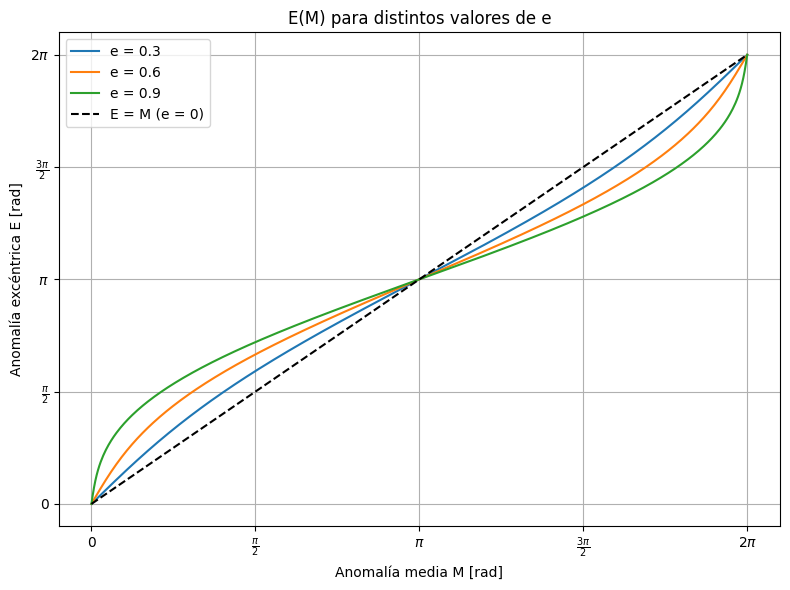

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter

def kepler_E(M, e, tol=1e-10, max_iter=100):
    E = M if e < 0.8 else np.pi
    for _ in range(max_iter):
        f = E - e * np.sin(E) - M
        fp = 1 - e * np.cos(E)
        delta = -f / fp
        E += delta
        if abs(delta) < tol:
            break
    return E

e_list = [0.3, 0.6, 0.9]
M_vals = np.linspace(0, 2*np.pi, 500)

plt.figure(figsize=(8,6))
for e in e_list:
    E_vals = [kepler_E(M, e) for M in M_vals]
    plt.plot(M_vals, E_vals, label=f"e = {e}")

plt.plot(M_vals, M_vals, 'k--', label="E = M (e = 0)")

def pi_formatter(x, pos):
    multiples = {0: "0",
                 np.pi/2: r"$\frac{\pi}{2}$",
                 np.pi: r"$\pi$",
                 3*np.pi/2: r"$\frac{3\pi}{2}$",
                 2*np.pi: r"$2\pi$"}
    return multiples.get(x, f"{x/np.pi:.1f}π")

plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi/2))
plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
plt.gca().yaxis.set_major_locator(MultipleLocator(base=np.pi/2))
plt.gca().yaxis.set_major_formatter(FuncFormatter(pi_formatter))

plt.xlabel("Anomalía media M [rad]")
plt.ylabel("Anomalía excéntrica E [rad]")
plt.title("E(M) para distintos valores de e")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


-------------------------------------------------------------------------
Angulo de giro de flyby en función del angulo de apuntado

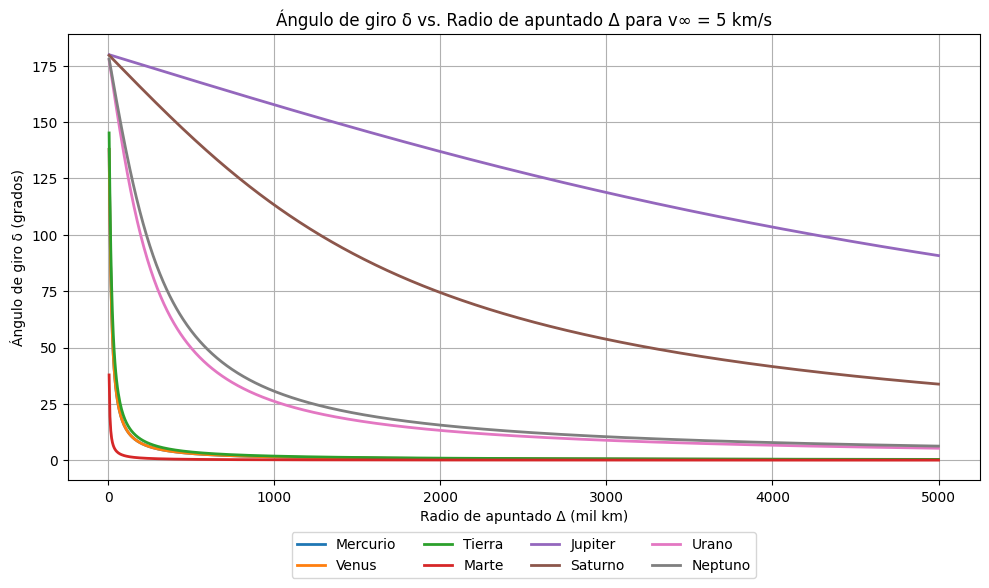

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes gravitacionales (km^3/s^2)
mu_Sol = 1.327e11  # km^3/s^2

# Velocidad hiperbólica (km/s)
v_inf = 5

delta_range = np.linspace(5000, 5000000, 1000)

# Parámetros gravitacionales
planetas = {
    "Mercurio": 3.248586e5,
    "Venus": 3.248586e5,
    "Tierra": 3.986004418e5,
    "Marte": 4.282837e4,
    "Jupiter": 1.2668653e8,
    "Saturno": 3.7931184e7,
    "Urano": 5.793118e6,
    "Neptuno": 6.835835e6
}

plt.figure(figsize=(10, 6))

for planeta, mu in planetas.items():
    delta = 2 * np.arcsin(1 / np.sqrt(1 + (delta_range**2 * v_inf**4) / mu**2))
    delta_deg = np.degrees(delta)
    plt.plot(delta_range / 1000, delta_deg, label=planeta, linewidth=2)

plt.xlabel('Radio de apuntado Δ (mil km)')
plt.ylabel('Ángulo de giro δ (grados)')
plt.title('Ángulo de giro δ vs. Radio de apuntado Δ para v∞ = 5 km/s')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=4)
plt.tight_layout()
plt.show()
